# Document Clustering

### Load packages

In [1]:
library('tm')
library('SnowballC')
library('ramify')

Loading required package: NLP
Warning message:
"package 'NLP' was built under R version 3.5.2"

## Soft-EM Implementation

In [2]:
eps=1e-10
  
# reading the data
read.data <- function(file.name='data/documents.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  
  # change dataframe format for datasource
  doc_id.df  <- data.frame(1:nrow(docs))
  colnames(doc_id.df)  <- "doc_id"
  colnames(docs)  <- "text"
  docs  <- cbind(doc_id.df, docs)
                                   
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

In [3]:
## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [4]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1) # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1) # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

In [6]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
E.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## this is actually log of gamma .....(1)
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ  # because log(x/y) is log(x) - log(y)
  }
  
  # converting back from the log space. Why? See note (1)
  gamma <- exp(gamma)
  return (gamma)
}

In [7]:

##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

  
  # M step:
  
  # Calculate Mixing Components rho
  Nk <- as.matrix(colSums(gamma))
  rho <- Nk/N
  model$rho <- rho # update model rho

  # Calculate Word proportion parameters
  mu <- as.matrix(t(counts %*% gamma)) # calculate mu
  
  # adding eps to avoid divide by zero error
  mu <- sweep(x = mu, MARGIN = 1, STATS = eps, FUN = "+")
  
  normalized_mu <- mu/rowSums(mu) # Normalize Mu
  model$mu <- normalized_mu # update model mu

  # Return the result
  return (model)
}


In [8]:
##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts)
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}


In [11]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

In [9]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}


Load Task2A.txt file and necessary libraries, set the number of clusters K=4, and run both the soft-EM.

[1] 2172681
[1] 1952754
[1] 1933806
[1] 1920770
[1] 1915022
[1] 1910102


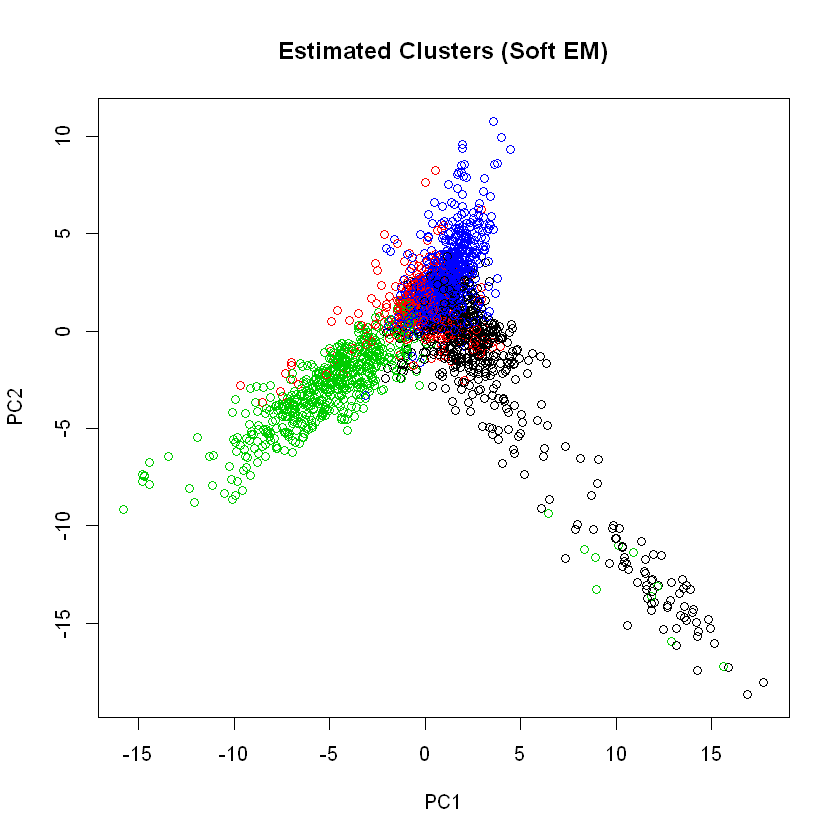

In [14]:
# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data
res <- EM(counts, K=4, max.epoch=5)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')


We choose 4 clusters to be formed on our data in all the plots.

We can see the plot of real clusters formed after performing PCA. PCA is the method used for dimensionality reduction based on covariance structure of variables through linear combinations.

## Hard EM Implementation

In [66]:
#----E step for hard EM-------
hard.E.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  #   E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
 
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  } 
  # converting back from the log space 
  gamma <- exp(gamma)
  
  return (gamma)
}

In [67]:
##--- M Step for Hard Clustering  --------------------------------------------
hard.M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  
  # M step:
  
  # perform hard assignments
  ## So, we will assign 1 for the class having highest probs and elsewhere 0.
  max.prob <- gamma==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
  gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
  gamma[!max.prob] <- 0 
  
  # Calculate Mixing Components rho
  Nk <- as.matrix(colSums(gamma))
  rho <- Nk/N
  model$rho <- rho # update model rho

  # Calculate Word proportion parameters
  mu <- as.matrix(t(counts %*% gamma)) # calculate mu
  
  # adding eps to avoid divide by zero error
  mu <- sweep(x = mu, MARGIN = 1, STATS = eps, FUN = "+")
  
  normalized_mu <- mu/rowSums(mu) # Normalize Mu
  model$mu <- normalized_mu # update model mu

  # Return the result
  return (model)
}


In [69]:
##--- Hard-EM for Document Clustering --------------------------------------------
hard.EM <- function(counts, K=4, max.epoch=10, seed=123456){
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words 
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)
    
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- hard.E.step(gamma, model, counts)
    # M Step
    model <- hard.M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

Run hard-EM algorithms on the provided data

[1] 1949278
[1] 1934466
[1] 1928284
[1] 1925259
[1] 1923827


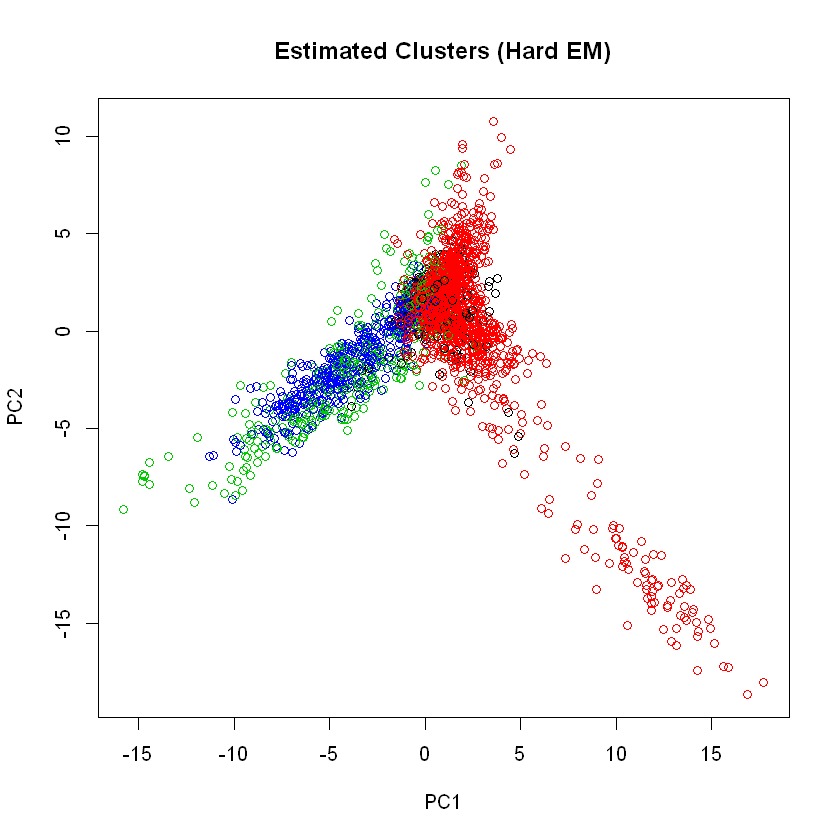

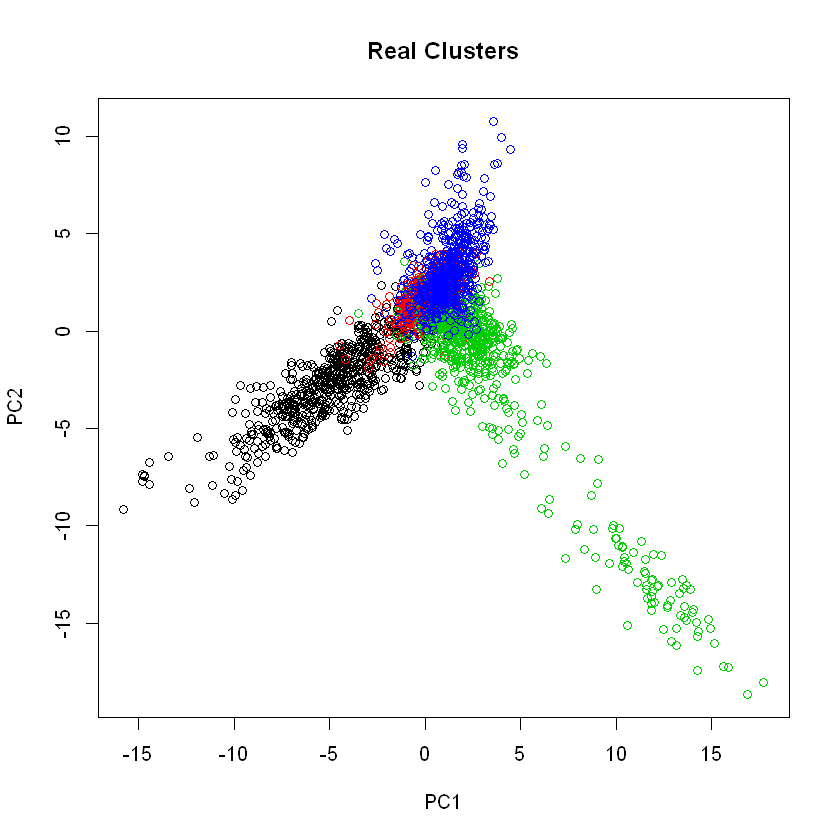

In [70]:

### main body ##################################################################

# Reading documents 
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        

# calling the EM algorithm on the data
res <- hard.EM(counts, K=4, max.epoch=5)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Hard EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')


Based on the above plots, we can see that clustering performed by Soft EM resembles with what we see as Real clusters compared with Hard EM. So Soft EM appears to be more accurate than Hard EM. (Red part in Hard EM is not clustered properly). 

Soft EM considers true probability of each data point in all the classes for maximization step, which leads to better results, and for data point its probability of belonging to each class is considered. On the other hand, in hard EM, the data point only belongs to 1 cluster. Hard EM just considers probability of 1 to the class having highest probability and 0 for the rest classes (completely remove others from the cluster) for each data instance for maximization step. In this way, hard EM penalizes the true value of probability by making it 1 for a class and 0 for others so EM iterations, negative log likelihood (log P(counts|label)) decreases slowly compared with what we get in soft-EM.
